In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels
import statsmodels.stats.diagnostic as sm_diagnostic
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [ ]:
df = pd.read_excel('fully_data.xlsx')
print(df.shape)
df.head()

(123, 38)


,Название фильма,GoodReviewVoteCount,FilmCritics,MPAA,ratingKinopoisk,year,Length,AgeLimits,countries,criminal,...,anime,vestern,reliase date,sequel,star_power,SJW,weekend,season,box_office,budget
0,John Wick: Chapter 4,67,8.2,r,7.6,2023,169,age18,"США, Германия",1,...,0,0,24.03.23,1,0,0,0,0,440180275,90000000
1,Oppenheimer,113,8.6,r,8.1,2023,180,NaN,"США, Великобритания",0,...,0,0,21.07.23,0,7,0,0,1,975811333,100000000
2,Barbie,61,8.0,pg13,6.6,2023,114,age18,"США, Великобритания",0,...,0,0,21.07.23,0,0,1,0,1,1447038421,100000000
3,Civil War,35,7.5,r,6.3,2023,109,age18,"США, Великобритания, Финляндия",0,...,0,0,12.04.24,0,1,0,0,0,127337886,50000000
4,Guardians of the Galaxy Vol. 3,74,7.2,pg13,8.1,2023,150,NaN,"США, Франция, Канада, Новая Зеландия",0,...,0,0,05.05.23,1,0,1,0,0,845555777,250000000


# 1. Описательные статистики

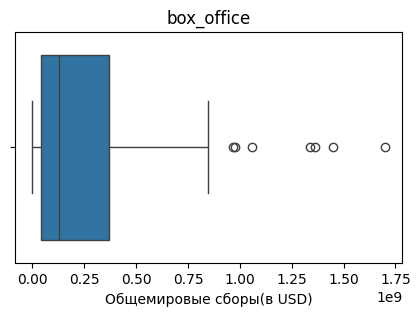

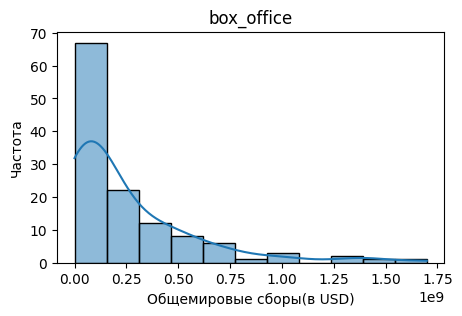

In [ ]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=df, x='box_office')
plt.title('box_office')
plt.xlabel('Общемировые сборы(в USD)')
plt.show()

plt.figure(figsize=(5, 3))
sns.histplot(df['box_office'], kde=True, bins=11)
plt.title('box_office')
plt.xlabel('Общемировые сборы(в USD)')
plt.ylabel('Частота')
plt.show()

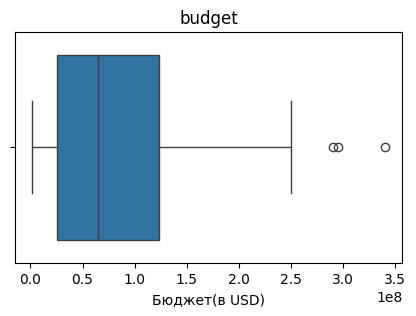

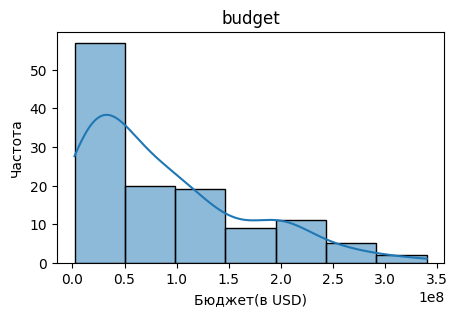

In [ ]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=df, x='budget')
plt.title('budget')
plt.xlabel('Бюджет(в USD)')
plt.show()

plt.figure(figsize=(5, 3))
sns.histplot(df['budget'], kde=True, bins=7)
plt.title('budget')
plt.xlabel('Бюджет(в USD)')
plt.ylabel('Частота')
plt.show()

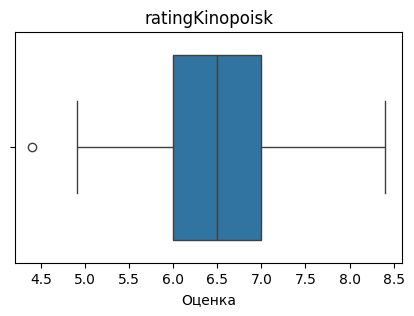

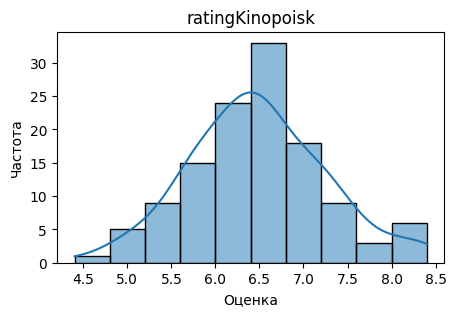

In [ ]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=df, x='ratingKinopoisk')
plt.title('ratingKinopoisk')
plt.xlabel('Оценка')
plt.show()

plt.figure(figsize=(5, 3))
sns.histplot(df['ratingKinopoisk'], kde=True)
plt.title('ratingKinopoisk')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show()

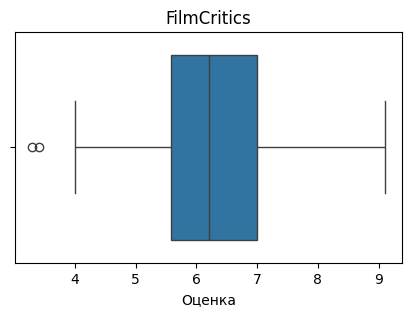

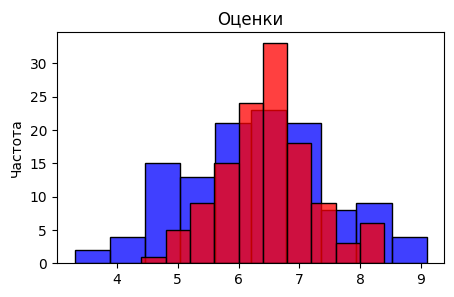

In [ ]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=df, x='FilmCritics')
plt.title('FilmCritics')
plt.xlabel('Оценка')
plt.show()

plt.figure(figsize=(5, 3))
sns.histplot(df['FilmCritics'], kde=False, color='blue', label='Критики', bins=10, multiple='dodge')
sns.histplot(df['ratingKinopoisk'], kde=False, color='red', label='Кинопоиск', bins=10, multiple='dodge')
plt.title('Оценки')
plt.xlabel('')
plt.ylabel('Частота')
plt.show()

# 2. Построение линейной регрессии (из статьи)

### 2.1 Построим модель, описанную в статье.

То есть линейную регрессию на кассовые сборы от производственных затрат, зрительских и профессиональных оценок, возрастного рейтинга, звездности фильма, его жанра даты выпуска и того является ли он сиквелом.

Так как в оригинальной работе для жанра использовалась одна дамми-переменная, которая равнялась 0, если жанром была драма и 1 в остальных случаях, то было принято решение протестировать несколько регрессий для разных конфигураций переменных

In [ ]:
# Создаем новый столбец 'dummy_drama'
df['dummy_drama'] = (~df['drama'].astype(bool)).astype(int)

#Преобразуем категориальные переменные в числовые
df['R'] = (df['MPAA'] != 'G').astype(int)


Как было замечено в процессе оценки моделей, в данных содержатся фильмы, для которых ненаблюдаются некоторый значения из-за чего модель не может быть корректно оценена, поэтому было принято решение их удалить.

In [ ]:
# Создаем копию данных для безопасности
data = df.copy()

# Удаляем строки, где есть хотя бы одно NaN значение в выбранных столбцах
data = data.dropna(subset=[
    'budget',
    'FilmCritics',
    'star_power',
    'dummy_drama',
    'sequel',
    'season',
    'weekend',
    'box_office'
])

# Проверяем результат
print(f"Было строк: {len(df)}, стало: {len(data)}")
print(f"Удалено строк: {len(df) - len(data)}")

Было строк: 123, стало: 120
Удалено строк: 3


Заметим, что в данных отсутсвуют фильмы, для которых рейтинг бы являлся G, поэтому данная переменная будет лишь константой в модели, поэтому было принято решение ее исключить.

In [ ]:
#Оригинальная модель
X = data[['budget', 'FilmCritics', 'star_power', 'dummy_drama', 'sequel', 'season', 'weekend']]
y = data['box_office']

# Преобразуем все данные в числовой формат (на всякий случай)
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

X = sm.add_constant(X)
model_1 = sm.OLS(y, X).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     13.79
Date:                Wed, 07 May 2025   Prob (F-statistic):           8.95e-13
Time:                        21:20:39   Log-Likelihood:                -2485.2
No. Observations:                 120   AIC:                             4986.
Df Residuals:                     112   BIC:                             5009.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.998e+08   1.41e+08     -3.536      

In [ ]:
# Поиск выбросов
influence = model_1.get_influence()
inf_sum = influence.summary_frame()

outliers = inf_sum[inf_sum['student_resid'] > 3]
outliers_index = outliers.index
print(outliers_index)

Index([1, 2, 31, 73], dtype='int64')


Так как в данных присутсвуют выбросы и их количество мало по сравнению с датасетом, то было принято решение их удалить

In [ ]:
# Удаляем строки с указанными индексами
data = data.drop(index=[1, 2, 31, 73])

# Проверяем результат
print(f"Размер после удаления: {data.shape}")

Размер после удаления: (116, 40)


In [ ]:
# Рассчет VIF для проверки мультиколениарности
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF:\n", vif_data)

VIF:
        feature        VIF
0        const  39.260163
1       budget   1.376874
2  FilmCritics   1.155352
3   star_power   1.309966
4  dummy_drama   1.302034
5       sequel   1.350433
6       season   1.072215
7      weekend   1.046479


То есть мультиколениарности в модели нет, константа искусственно завышена и всегда игнорируется

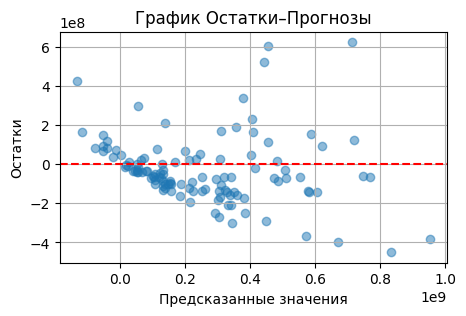

In [ ]:
#Распределние остатков
data['fitted'] = model_1.fittedvalues
data['residuals'] = model_1.resid

plt.figure(figsize=(5, 3))
plt.scatter(data['fitted'], data['residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График Остатки–Прогнозы')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.grid()
plt.show()

In [ ]:
from statsmodels.stats.diagnostic import het_white
# Тест Уайта
white_test = het_white(model_1.resid, model_1.model.exog)
white_test_results = pd.Series(white_test, index=['Лямбда', 'p-значение', 'F-статистика', 'p-значение F'])
print("\nТест Уайта:\n", white_test_results)


Тест Уайта:
 Лямбда          19.103906
p-значение       0.007868
F-статистика     3.029478
p-значение F     0.005914
dtype: float64


Из графика видно, что остатки дейсвительно распределены неравномерно и  в данных присутсвует гетероскедастичность, с которой необходимо бороться, что подтвержается тестом Уайта.

### 2.2 Пропробуем переоценить прошлую модель с учетом выводов выше

In [ ]:
X_2 = data[['budget', 'FilmCritics', 'star_power', 'dummy_drama', 'sequel', 'season', 'weekend']]
y = data['box_office']

X_2 = sm.add_constant(X_2)
model_2 = sm.OLS(y, X_2).fit(cov_type='HC3')
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     5.071
Date:                Wed, 07 May 2025   Prob (F-statistic):           0.000128
Time:                        21:20:39   Log-Likelihood:                -2359.0
No. Observations:                 116   AIC:                             4734.
Df Residuals:                     108   BIC:                             4756.
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -2.98e+08   1.11e+08     -2.682      

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# Рассчет VIF для проверки мультиколениарности
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF:\n", vif_data)

VIF:
        feature        VIF
0        const  39.260163
1       budget   1.376874
2  FilmCritics   1.155352
3   star_power   1.309966
4  dummy_drama   1.302034
5       sequel   1.350433
6       season   1.072215
7      weekend   1.046479


Проверим еще раз выбросы
1. Стюдентизированные остатки

In [ ]:
influence = model_2.get_influence()
inf_sum = influence.summary_frame()

outliers = inf_sum[inf_sum['student_resid'] > 3]
outliers_index = outliers.index
print(outliers_index)

Index([72, 81, 87], dtype='int64')


2. Точки левериджа

In [ ]:
leverage = influence.hat_matrix_diag
cutoff_leverage = (2*8)/116 # Определим пороговое значение для точек левериджа: 2*k/n
high_leverage = pd.DataFrame(([abs(leverage) > cutoff_leverage])).T
high_leverage = leverage > cutoff_leverage

In [ ]:
# Создаем чистый датафрейм без выбросов
df_clean = data[~high_leverage].copy()

# Пересчитываем модель на очищенных данных
X_clean = df_clean[['budget', 'FilmCritics', 'star_power', 'dummy_drama', 'sequel', 'season', 'weekend']]
X_clean = sm.add_constant(X_clean)
y_clean = df_clean['box_office']

model_clean = sm.OLS(y_clean, X_clean).fit(cov_type='HC3')
print(model_clean.summary())

                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     5.380
Date:                Wed, 07 May 2025   Prob (F-statistic):           0.000194
Time:                        21:20:39   Log-Likelihood:                -2256.5
No. Observations:                 111   AIC:                             4527.
Df Residuals:                     104   BIC:                             4546.
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.859e+08   1.17e+08     -2.447      

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 5
  warnings.warn('covariance of constraints does not have full '


Проверим новый датафрейм, который образовался после удаления выбросов.


In [ ]:
df_clean['weekend'].describe()

,weekend
count,111.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


Так как после удаления выбросов не осталось положительных значений в выходных, то их необходимо удалить.

In [ ]:
# Удаляем 'weekend' (все значения = 0)
X_clean = X.drop(['weekend'], axis=1)
model_clean = sm.OLS(y, X_clean).fit(cov_type='HC3')
print(model_clean.summary())

ValueError: The indices for endog and exog are not aligned

### 2.3 Пробуем изменить функциональную форму
Для избавления от гетероскедастичности попробуем прологарифмировать кассовые сборы

In [ ]:
# 1. Подготовка данных
X = data[['budget', 'FilmCritics', 'star_power', 'dummy_drama', 'sequel', 'season', 'weekend']].copy()
y = data['box_office'].copy()

# 2. Логарифмирование с обработкой нулей и отрицательных значений
y_log = np.log(y.replace(0, np.nan))  # Замена нулей на NaN перед логарифмированием

X_clean = sm.add_constant(X)
model_log = sm.OLS(y_log, X_clean).fit()
print(model_log.summary())

Пропробуем прологарифмировать кассовые сборы и бюджет

In [ ]:
# Логарифмируем переменные (добавляем малую константу для избежания log(0))
data['log_box_office'] = np.log(data['box_office'] + 1)
data['log_budget'] = np.log(data['budget'] + 1)

# 2. Спецификация модели
X_log = data[['log_budget', 'FilmCritics', 'star_power', 'dummy_drama', 'sequel', 'season', 'weekend']]
X_log = sm.add_constant(X_log)  # Добавляем константу
y_log = data['log_box_office']

# 3. Построение модели
model_log = sm.OLS(y_log, X_log).fit(cov_type='HC3')
print(model_log.summary())

В этой модели четко видна убывающая отдача от бюджета

### 2.4 Взвешенный МНК для МНК из статьи УДАЛИТЬ!!!!!

In [ ]:
# Взвешенный МНК

# Расчет весов с защитой от ошибок
# На основе остатков
weights = 1/(0.1 + np.abs(model_2.resid))

#Взвешенная регрессия
model_wls = sm.WLS(y, sm.add_constant(X_2), weights=weights).fit(cov_type='HC3')
print(model_wls.summary())

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_2.columns
vif_data["VIF"] = [variance_inflation_factor(X_2.values, i) for i in range(X_2.shape[1])]

print("VIF:\n", vif_data)

In [ ]:
print(-2.752e+08)

### Попробуем стандартизировать регрессоры, чтобы избавиться от вырожденной матрицы.

In [ ]:
from sklearn.preprocessing import StandardScaler
# Стандартизируем факторы
x_scaled = StandardScaler().fit_transform(X_2)
model = sm.WLS(y, x_scaled)  # создаем модель Взвешенного МНК (пока без весов)

# Расчет весов с защитой от ошибок (чтобы избежать деления на 0)
# На основе остатков от обычной OLS модели
model_ols = sm.OLS(y, x_scaled).fit()  # сначала строим обычную OLS модель
weights = 1/(0.1 + np.abs(model_ols.resid))  # добавляем 0.1 для устойчивости

# Пересоздаем взвешенную модель с вычисленными весами
model_wls_2 = sm.WLS(y, sm.add_constant(x_scaled), weights=weights).fit(cov_type='HC3')
print(model_wls_2.summary())

 ### 2.5 Оценим вторую модель из статьи, которая включает перекрестную переменную

In [ ]:
#Включение Interaction Variable
data['B*C'] = data['budget'] * data['FilmCritics']

In [ ]:
# МНК оценка с включеной переменной
X_BC = data[['budget', 'FilmCritics', 'star_power', 'dummy_drama', 'sequel', 'season', 'weekend', 'B*C']]
y = data['box_office']

X_BC = sm.add_constant(X_BC)
model_BC = sm.OLS(y, X_BC).fit(cov_type='HC3')
print(model_BC.summary())

In [ ]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X_BC.columns  # X — матрица предикторов
vif_data["VIF"] = [variance_inflation_factor(X_BC.values, i) for i in range(X_BC.shape[1])]
print(vif_data)

В модели появилась сильная мультиколлениарность, которую нужно попытаться исключить. Попробуем центрировать данные.


In [ ]:
data['budget_centered'] = data['budget'] - data['budget'].mean()
data['FilmCritics_centered'] = data['FilmCritics'] - data['FilmCritics'].mean()
data['B*C_2'] = data['budget_centered'] * data['FilmCritics_centered']

In [ ]:
# МНК оценка с включеной переменной
X_BC = data[['budget', 'FilmCritics', 'star_power', 'dummy_drama', 'sequel', 'season', 'weekend', 'B*C_2']]
y = data['box_office']

X_BC = sm.add_constant(X_BC)
model_BC = sm.OLS(y, X_BC).fit(cov_type='HC3')
print(model_BC.summary())

In [ ]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X_BC.columns  # X — матрица предикторов
vif_data["VIF"] = [variance_inflation_factor(X_BC.values, i) for i in range(X_BC.shape[1])]
print(vif_data)

Заметим, что от мультиколениарности удалось избавиться.

## 2.6 Оценка регрессии с дополнительными факторами

При построении этой регрессии было принято решение включить зрительскую оценку, дамми-переменную на инклюзивность кинолент и некоторые жанры, которые были упомянуты в статье. В дальнейшем будет оценено несколько моделей для выбора наилучшей.


In [ ]:
#Обычная МНК модель
X_our = data[['budget', 'FilmCritics', 'ratingKinopoisk', 'Length', 'sequel', 'season', 'weekend', 'SJW','star_power', 'action movie', 'comedy', 'drama']]
y_our = data['box_office']
X_our = sm.add_constant(X_our)

model_our_1 = sm.OLS(y_our, X_our).fit(cov_type='HC3')
print(model_our_1.summary())

In [ ]:
# Рассчет VIF для проверки мультиколениарности
vif_data = pd.DataFrame()
vif_data["feature"] = X_our.columns
vif_data["VIF"] = [variance_inflation_factor(X_our.values, i) for i in range(X_our.shape[1])]

print("VIF:\n", vif_data)

Мультиколениарности не обнаружено

In [ ]:
#Распределние остатков
data['fitted'] = model_our_1.fittedvalues
data['residuals'] = model_our_1.resid

plt.figure(figsize=(5, 3))
plt.scatter(data['fitted'], data['residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График Остатки–Прогнозы')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.grid()
plt.show()

Судя по графику в модели есть ненормальные остатки, с которыми необходимо бороться (это подтверждается и значениями Jarque-Bera (JB)). Поэтому попробуем прологарифмировать сначала кассовые сборы, а потом кассовые сборы и бюджет.

In [ ]:
# Логарифмируем box_office и budget
data['log_box_office'] = np.log(data['box_office'] + 1)
data['log_budget'] = np.log(data['budget'] + 1)

# Убираем незначимые переменные (например, 'comedy', 'drama')
X_clean = X_our.drop(['comedy', 'drama', 'weekend'], axis=1)

# Запускаем OLS
model_final = sm.OLS(data['log_box_office'], X_clean).fit(cov_type='HC3')
print(model_final.summary())

In [ ]:
X = data[['log_budget', 'FilmCritics', 'ratingKinopoisk', 'Length', 'sequel', 'season', 'weekend', 'SJW','star_power', 'action movie', 'comedy', 'drama']]
X = sm.add_constant(X)
y = data['log_box_office']
model_log = sm.OLS(y, X).fit(cov_type='HC3')
print(model_log.summary())

In [ ]:
from scipy.stats import boxcox
data['box_office_bc'], _ = boxcox(data['box_office'] + 1)

X = data[['log_budget', 'FilmCritics', 'ratingKinopoisk', 'Length', 'sequel', 'season', 'weekend', 'SJW','star_power', 'action movie', 'comedy', 'drama']]
X = sm.add_constant(X)
y = data['box_office_bc']
model_log = sm.OLS(y, X).fit(cov_type='HC3')
print(model_log.summary())

In [ ]:
from scipy.stats import boxcox
data['box_office_bc'], _ = boxcox(data['box_office'] + 1)

X = data[['budget', 'FilmCritics', 'ratingKinopoisk', 'Length', 'sequel', 'season', 'weekend', 'SJW','star_power', 'action movie', 'comedy', 'drama']]
X = sm.add_constant(X)
y = data['box_office_bc']
model_log = sm.OLS(y, X).fit(cov_type='HC3')
print(model_log.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 11
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:          box_office_bc   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     6.766
Date:                Wed, 07 May 2025   Prob (F-statistic):           1.89e-08
Time:                        21:20:39   Log-Likelihood:                -493.39
No. Observations:                 116   AIC:                             1013.
Df Residuals:                     103   BIC:                             1049.
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              45.1905     17.531     

# 3. Построение дополнительной модели: RDD

Проверим нулевую гипотезу:

H0: Основные факторы влияющие на кассовые сборы не отличаются в 2023 и 2024 годах.

H1: Влиятельные факторы различны (то есть большую значимость оказывают иные переменные)

In [ ]:
# Предобработка
df['post_2023'] = (df['year'] == 2024).astype(int)

# Выбираем признаки
X_base = ['budget', 'FilmCritics', 'star_power', 'Length', 'sequel', 'season', 'weekend', 'SJW']
X = df[X_base]
y = df['box_office']

In [ ]:
# Добавляем переменные взаимодействия
for col in X_base:
    df[f'{col}_x_post'] = df[col] * df['post_2023']

# Конструируем матрицу признаков
X_full = df[X_base + ['post_2023'] + [f'{col}_x_post' for col in X_base]]
X_full = sm.add_constant(X_full)

In [ ]:
# Проверка на NaN и inf
print("Есть ли NaN:", X_full.isnull().values.any())
print("Есть ли inf:", np.isinf(X_full).values.any())

# Удаление строк с NaN или inf
X_full_clean = X_full.replace([np.inf, -np.inf], np.nan).dropna()
y_clean = y.loc[X_full_clean.index]  # не забудь подогнать y под очищенные X

Есть ли NaN: True
Есть ли inf: False


In [ ]:
# Преобразование булевых в int
X_full_clean = X_full_clean.astype(float)

Создаем бинарную переменную post_2023 = 1, если year == 2024.
Добавить переменные взаимодействия X * post_2023.
Теперь строим регрессионную модель:

y=β0 +β1 X+β2 post_2023+β3 (X⋅post_2023)+ ε


Коэффициенты при взаимодействиях (
β3 ) покажут, насколько изменился вклад переменных в 2024 году.

Проверка гипотезы:

H0: Коэффициенты взаимодействий (β3) незначимы или влияние переменных не изменилось.

H1: Некоторые
β3  значимы, то есть влияние факторов изменилось в 2024 году.

Смотрим на p-value у переменных x post.

In [ ]:
# Строим модель
model = sm.OLS(y_clean, X_full_clean).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     8.308
Date:                Wed, 07 May 2025   Prob (F-statistic):           8.81e-13
Time:                        22:16:04   Log-Likelihood:                -2470.3
No. Observations:                 120   AIC:                             4977.
Df Residuals:                     102   BIC:                             5027.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.803e+08   2.11

y=β0 +β1* X1 +β2 *X2 +β3* X3 +⋯+βn *Xn +βpost ⋅post_2023+β1post (X1 ⋅post_2023)+β2post (X2 ⋅post_2023)+⋯+βnpost (Xn ⋅post_2023)+ ϵ


Где:
y — это зависимая переменная (в данном случае box_office),
X1 ,X2 ,X3 ,…,Xn  — это независимые переменные (например, budget, FilmCritics, и т. д.),


β0  — это свободный член (константа),
β1 ,β2 ,…,βn  — коэффициенты для переменных X
βpost  — коэффициент для переменной post_2023,
,
…
bpost ,β2post ,…,βnpost  — коэффициенты для переменных взаимодействия (переменные X, умноженные на post_2023), ϵ — ошибка модели.

Для проверки гипотезы H0 и H1 важно анализировать p-value для коэффициентов взаимодействия (x post). Если p-value для коэффициента взаимодействия больше уровня значимости (0.05), мы не отвергаем гипотезу H0.


p-value < 0.05: переменная взаимодействия значима (мы отвергаем H0).
p-value >= 0.05: переменная взаимодействия незначима (мы не отвергаем H0).


budget_x_post: p-value = 0.168 → не значимо
FilmCritics_x_post: p-value = 0.145 → не значимо
star_power_x_post: p-value = 0.275 → не значимо
Length_x_post: p-value = 0.309 → не значимо
sequel_x_post: p-value = 0.203 → не значимо
season_x_post: p-value = 0.432 → не значимо
weekend_x_post: p-value = 0.901 → не значимо
SJW_x_post: p-value = 0.175 → не значимо


Все переменные взаимодействия имеют p-value > 0.05, что означает, что они не значимы.
Таким образом, H0 не отвергается, и можно сделать вывод, что влияние переменных не изменилось в 2024 году.

Проверим другую гипотезу:

H0: В 2024 году основные показатели для выпущенных фильмов были ниже, чем в 2023 году.

H1: Показатели примерно совпадают или же в 2024 году были значительно ниже.

In [ ]:
# Разделяем данные по годам
df_2023 = df[df['year'] == 2023]['box_office']
df_2024 = df[df['year'] == 2024]['box_office']

# Применяем t-тест для независимых выборок
t_stat, p_value = stats.ttest_ind(df_2023, df_2024, alternative='less')

# Выводим результаты
print("t-статистика:", t_stat)
print("p-value:", p_value)

# Оценка гипотезы
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу H0, кассовые сборы в 2024 году значительно ниже, чем в 2023.")
else:
    print("Не отвергаем нулевую гипотезу H0, кассовые сборы в 2024 году не ниже, чем в 2023.")

t-статистика: -0.05007656741592756
p-value: 0.48007197100723675
Не отвергаем нулевую гипотезу H0, кассовые сборы в 2024 году не ниже, чем в 2023.


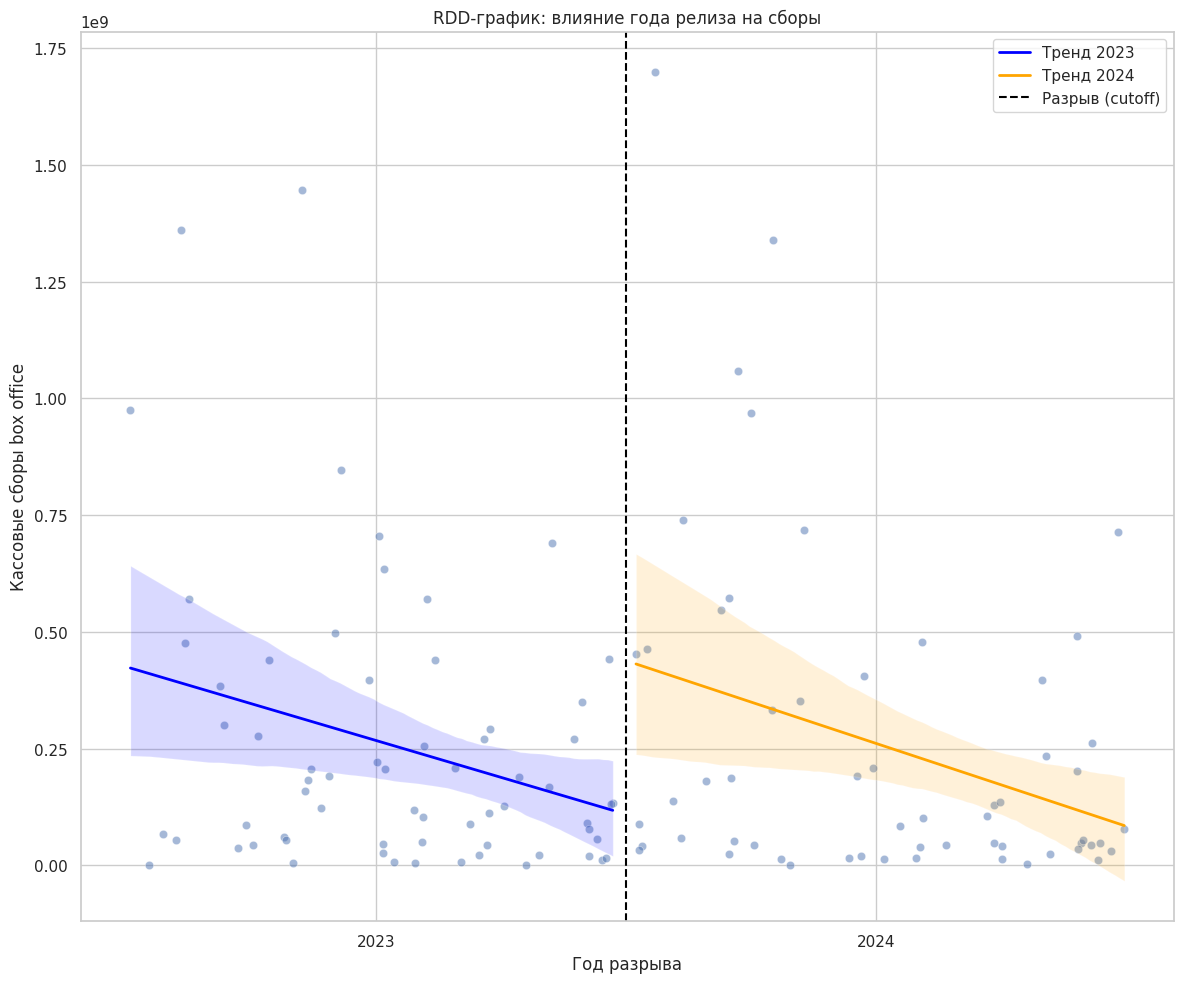

In [ ]:
# Сдвигаем облака ближе к центру
df['running_var'] = df['year'].apply(lambda x: -0.02 if x == 2023 else 0.02)

# Добавляем небольшой шум с меньшим диапазоном
df['running_var_jitter'] = df['running_var'] + (np.random.rand(len(df)) - 0.5) * 0.04

# Настройка стиля
sns.set(style="whitegrid")

# График
plt.figure(figsize=(12, 10))

# Облако точек
sns.scatterplot(x='running_var_jitter', y='box_office', data=df, alpha=0.5)

# Линия тренда 2023
sns.regplot(
    x='running_var_jitter', y='box_office',
    data=df[df['year'] == 2023],
    scatter=False, color='blue', label='Тренд 2023',
    line_kws={"linewidth": 2}
)

# Линия тренда 2024
sns.regplot(
    x='running_var_jitter', y='box_office',
    data=df[df['year'] == 2024],
    scatter=False, color='orange', label='Тренд 2024',
    line_kws={"linewidth": 2}
)

# Вертикальная линия — точка разрыва
plt.axvline(0, color='black', linestyle='--', label='Разрыв (cutoff)')

# Настройка осей
plt.xticks([-0.02, 0.02], ['2023', '2024'])
plt.xlabel('Год разрыва')
plt.ylabel('Кассовые сборы box office')
plt.title('RDD-график: влияние года релиза на сборы')
plt.legend()
plt.tight_layout()

# Сохранение графика
plt.savefig('rdd_graph.png')

# Показ графика
plt.show()


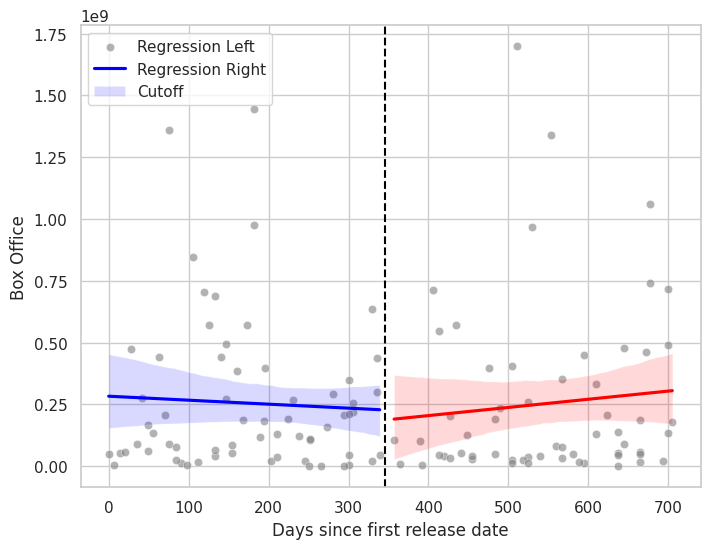

In [ ]:
# Преобразуем столбец 'reliase date' в datetime с учетом двухзначных годов
df['reliase date'] = pd.to_datetime(df['reliase date'], format='%d.%m.%y', errors='coerce')

# Преобразуем 'reliase date' в количество дней (целочисленные значения)
df['reliase date num'] = (df['reliase date'] - df['reliase date'].min()).dt.days

# Преобразуем столбец 'box_office' в числовой тип, заменяя нечисловые значения на NaN
df['box_office'] = pd.to_numeric(df['box_office'], errors='coerce')

# Разделяем данные на две группы
cutoff = '01.01.2024'
df_left = df[df['reliase date'] <= pd.to_datetime(cutoff, format='%d.%m.%Y')]
df_right = df[df['reliase date'] >= pd.to_datetime(cutoff, format='%d.%m.%Y')]

# Строим график
plt.figure(figsize=(8,6))

# Сначала рисуем все точки
sns.scatterplot(x='reliase date num', y='box_office', data=df, color='gray', alpha=0.6)

# Линия регрессии для данных слева от порога
sns.regplot(x='reliase date num', y='box_office', data=df_left, scatter=False, color='blue')

# Линия регрессии для данных справа от порога
sns.regplot(x='reliase date num', y='box_office', data=df_right, scatter=False, color='red')

# Добавляем вертикальную линию на порог (переводим cutoff в число дней)
cutoff_date_num = (pd.to_datetime(cutoff, format='%d.%m.%Y') - df['reliase date'].min()).days
plt.axvline(x=cutoff_date_num, color='black', linestyle='--')

# Настройки графика
plt.xlabel('Days since first release date')
plt.ylabel('Box Office')
plt.legend(['Regression Left', 'Regression Right', 'Cutoff'])
plt.show()